# Set up

In [127]:
import pandas as pd
import patsy
import numpy as np
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import PredefinedSplit, GridSearchCV, cross_val_score
from sklearn.decomposition import PCA
from skopt.space import Real, Integer
from skopt.utils import use_named_args
from skopt import gp_minimize
from sklearn.mixture import GaussianMixture
from sklearn.feature_selection import RFECV
from sklearn.linear_model import Lasso, LinearRegression, Ridge
from sklearn.tree import DecisionTreeRegressor, plot_tree
from mlens.ensemble import SuperLearner
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm

In [2]:
pd.set_option('display.max_columns', 1000)
pd.set_option('display.max_rows', 1000)

# Getting data

In [93]:
file_name = '../csvs/element_gameweek_features_v07.csv'

element_gameweek_df = pd.read_csv(file_name)

In [94]:
current_event = 38
last_train_event = 28

element_gameweek_df =\
element_gameweek_df[
    (element_gameweek_df['event'] <= current_event)
]

In [95]:
element_gameweek_df = pd.concat([
    element_gameweek_df[element_gameweek_df['element_type'] == i].fillna(
        element_gameweek_df[
            (element_gameweek_df['event'] <= last_train_event)
            & (element_gameweek_df['element_type'] == i)
        ].mean()).fillna(0)
    for i in range(1, 5)
])

In [96]:
element_gameweek_df['is_keeper'] = element_gameweek_df['element_type'].apply(lambda x: 1 if x == 1 else 0)

element_gameweek_df['is_scorer'] = \
element_gameweek_df['rolling_avg_goals_scored_element'].apply(lambda x: 1 if x >= 0.47 else 0)

element_gameweek_df['is_assister'] = \
element_gameweek_df['rolling_avg_assists_element'].apply(lambda x: 1 if x >= 0.5 else 0)

element_gameweek_df['is_high_value'] = \
element_gameweek_df['value'].apply(lambda x: 1 if x >= 9.0 else 0)

In [104]:
element_gameweek_df = element_gameweek_df[element_gameweek_df['rolling_avg_minutes_element_p3'] > 0]

# Exploring data

In [105]:
element_gameweek_df['total_points'].describe()

count    13495.000000
mean         2.204001
std          2.931628
min         -4.000000
25%          0.000000
50%          1.000000
75%          2.000000
max         23.000000
Name: total_points, dtype: float64

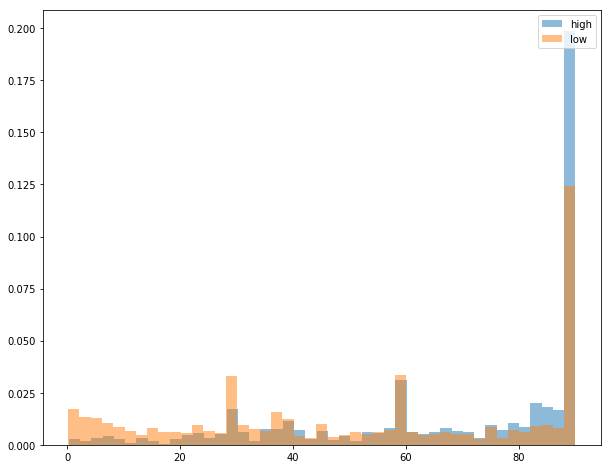

In [106]:
plt.figure(figsize=(10, 8))
plt.hist(
    element_gameweek_df[
        (~pd.isnull(element_gameweek_df['rolling_avg_minutes_element_p3']))
        & (element_gameweek_df['total_points'] >= 7)
    ]['rolling_avg_minutes_element_p3'],
    bins=45,
    label='high',
    density=True,
    alpha=0.5
        )
plt.hist(
    element_gameweek_df[
        (~pd.isnull(element_gameweek_df['rolling_avg_minutes_element_p3']))
        & (element_gameweek_df['total_points'] < 4)
    ]['rolling_avg_minutes_element_p3'],
    bins=45,
    label='low',
    density=True,
    alpha=0.5
        )
plt.legend(loc='upper right')
plt.show()

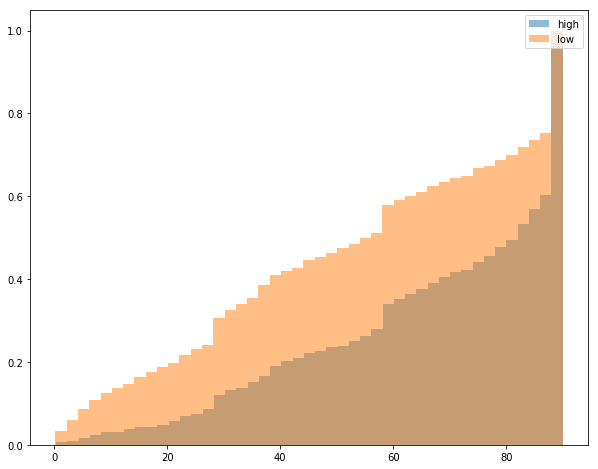

In [203]:
plt.figure(figsize=(10, 8))
plt.hist(
    element_gameweek_df[
        (~pd.isnull(element_gameweek_df['rolling_avg_minutes_element_p3']))
        & (element_gameweek_df['total_points'] >= 7)
#         & (element_gameweek_df['rolling_avg_minutes_element_p3'] >= 30)
    ]['rolling_avg_minutes_element_p3'],
    bins=45,
    label='high',
    density=True,
    alpha=0.5,
    cumulative=True
        )
plt.hist(
    element_gameweek_df[
        (~pd.isnull(element_gameweek_df['rolling_avg_minutes_element_p3']))
        & (element_gameweek_df['total_points'] < 4)
#         & (element_gameweek_df['rolling_avg_minutes_element_p3'] >= 30)
    ]['rolling_avg_minutes_element_p3'],
    bins=45,
    label='low',
    density=True,
    alpha=0.5,
    cumulative=True
        )
plt.legend(loc='upper right')
plt.show()

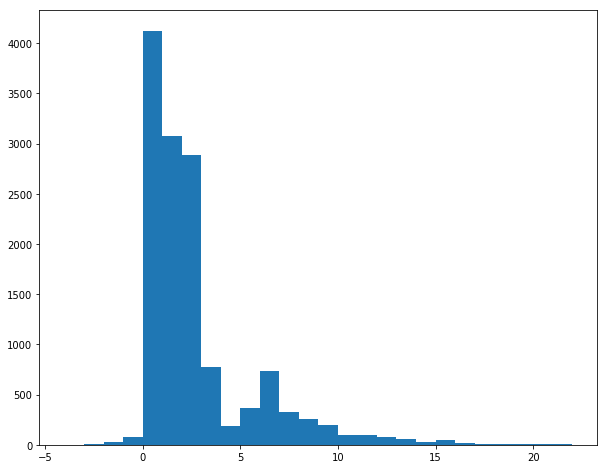

In [204]:
plt.figure(figsize=(10, 8))
plt.hist(
    element_gameweek_df[
        element_gameweek_df['rolling_avg_minutes_element_p3'] >= 0
    ]['total_points'],
    bins=range(-4, 23))
plt.show()

In [205]:
gauss_mix_model = GaussianMixture(
    n_components=2
)
gauss_mix_model.fit(
    np.array(
        element_gameweek_df[
            element_gameweek_df['rolling_avg_minutes_element_p3'] >= 0
    ]['total_points']
    ).reshape(-1, 1))

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
                means_init=None, n_components=2, n_init=1, precisions_init=None,
                random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
                verbose_interval=10, warm_start=False, weights_init=None)

In [206]:
print(gauss_mix_model.means_)
print(gauss_mix_model.covariances_)

[[0.9607893 ]
 [6.35566369]]
[[[ 0.90984476]]

 [[11.85641633]]]


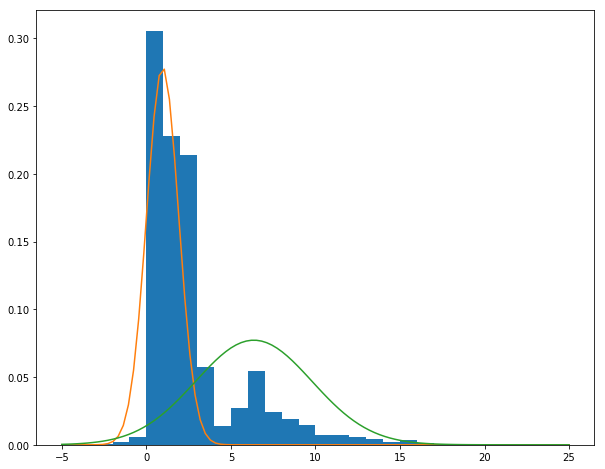

In [207]:
plt.figure(figsize=(10, 8))
plt.hist(
    element_gameweek_df[
            element_gameweek_df['rolling_avg_minutes_element_p3'] >= 0
    ]['total_points'],
    bins=range(-4, 23),
    density=True)

for i in range(0, 2):
    x = np.linspace(-5, 25, 100)
    plt.plot(x, norm.pdf(x, loc=gauss_mix_model.means_[i][0], scale=np.sqrt(gauss_mix_model.covariances_[i][0]))/1.5)
    
plt.show()

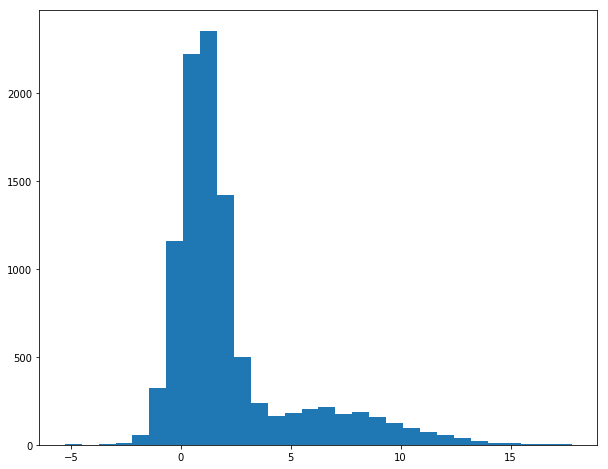

In [208]:
plt.figure(figsize=(10, 8))
plt.hist(
    gauss_mix_model.sample(10000)[0].ravel(),
    bins=30
)
plt.show()

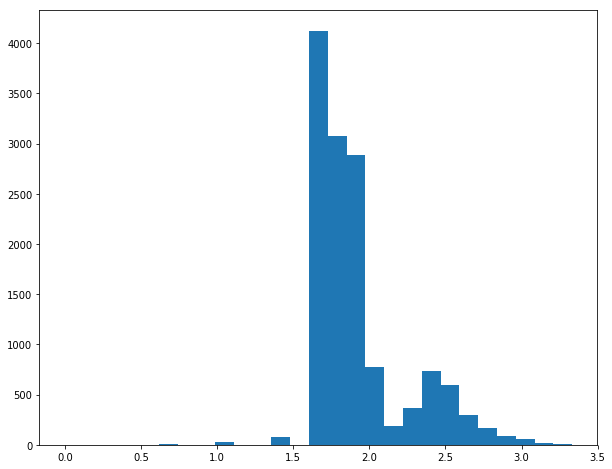

In [209]:
plt.figure(figsize=(10, 8))
plt.hist(
    np.log(element_gameweek_df['total_points'] + 5),
    bins=27
)
plt.show()

In [210]:
log_mix_model = GaussianMixture(
    n_components=2
)
log_mix_model.fit(
    np.array(np.log(element_gameweek_df['total_points'] + 5)).reshape(-1, 1)
)

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
                means_init=None, n_components=2, n_init=1, precisions_init=None,
                random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
                verbose_interval=10, warm_start=False, weights_init=None)

In [211]:
print(log_mix_model.means_)
print(log_mix_model.covariances_)

[[2.37343906]
 [1.76930407]]
[[[0.10049233]]

 [[0.0254628 ]]]


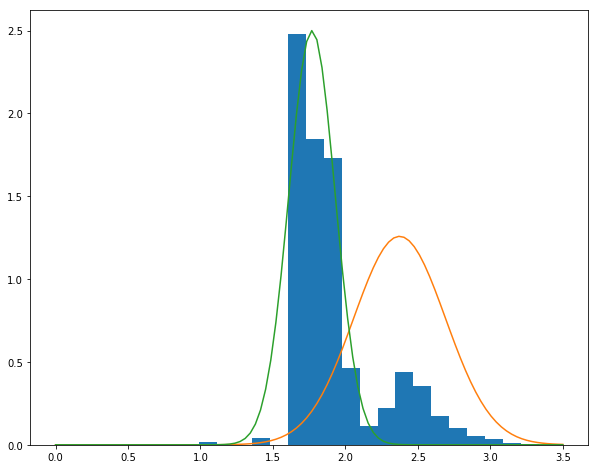

In [212]:
plt.figure(figsize=(10, 8))
plt.hist(np.log(element_gameweek_df['total_points'] + 5), bins=27, density=True)

for i in range(0, 2):
    x = np.linspace(0, 3.5, 100)
    plt.plot(x, norm.pdf(x, loc=log_mix_model.means_[i][0], scale=np.sqrt(log_mix_model.covariances_[i][0])))
    
plt.show()

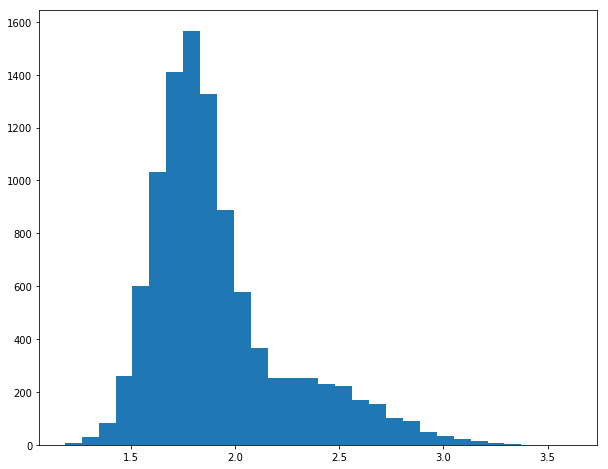

In [213]:
plt.figure(figsize=(10, 8))
plt.hist(
    log_mix_model.sample(10000)[0].ravel(),
    bins=30
)
plt.show()

# Resampling data

In [219]:
element_gameweek_df['is_low_points'] = [
    i[0] for i in 
    gauss_mix_model.predict_proba(
        np.array(element_gameweek_df['total_points']).reshape(-1, 1)
    )
]

element_gameweek_df['is_high_points'] = 1 - element_gameweek_df['is_low_points']

In [247]:
low_df_arr = []
for i in range(len(element_gameweek_df)):
    for j in range(int(element_gameweek_df.iloc[i]['is_low_points'] * 10)):
        low_df_arr.append(element_gameweek_df.iloc[i])
    
low_df = pd.DataFrame(low_df_arr)

high_df_arr = []
for i in range(len(element_gameweek_df)):
    for j in range(int(element_gameweek_df.iloc[i]['is_high_points'] * 10)):
        high_df_arr.append(element_gameweek_df.iloc[i])
    
high_df = pd.DataFrame(high_df_arr)

# Modelling data

## Splitting data

In [257]:
test_fold = [-1 if i <= last_train_event else 0 for i in element_gameweek_df['event']]
ps = PredefinedSplit(test_fold)

In [258]:
for train_index, test_index in ps.split():
    element_gameweek_df_train, element_gameweek_df_test = \
    element_gameweek_df.copy().iloc[train_index], element_gameweek_df.copy().iloc[test_index]

In [259]:
low_test_fold = [-1 if i <= last_train_event else 0 for i in low_df['event']]
low_ps = PredefinedSplit(low_test_fold)

In [260]:
for train_index, test_index in low_ps.split():
    low_df_train, low_df_test = \
    low_df.copy().iloc[train_index], low_df.copy().iloc[test_index]

In [261]:
high_test_fold = [-1 if i <= last_train_event else 0 for i in high_df['event']]
high_ps = PredefinedSplit(high_test_fold)

In [262]:
for train_index, test_index in high_ps.split():
    high_df_train, high_df_test = \
    high_df.copy().iloc[train_index], high_df.copy().iloc[test_index]

## Scaling data

In [264]:
scaled_feature_cols = [
    i for i in element_gameweek_df.columns if i not in [
        'safe_web_name', 'element', 'event', 'fixture', 'team',
        'opposition_team', 'element_type', 'was_home', 'is_sunday',
        'is_weekday', 'is_late', 'is_early', 'has_high_points_ever_element',
        'total_points', 'minutes', 'rolling_value_points', 'is_keeper',
        'is_scorer', 'is_assister', 'is_high_value', 'is_low_points',
        'is_high_points'
    ]
]

scaled_feature_cols

['value',
 'rolling_avg_total_points_element',
 'rolling_q3_total_points_element',
 'rolling_max_total_points_element',
 'rolling_avg_bps_element',
 'rolling_avg_bonus_element',
 'rolling_avg_goals_scored_element',
 'rolling_avg_minutes_element',
 'rolling_avg_clean_sheets_element',
 'rolling_avg_completed_passes_element',
 'rolling_avg_recoveries_element',
 'rolling_avg_assists_element',
 'rolling_avg_key_passes_element',
 'rolling_avg_winning_goals_element',
 'rolling_avg_tackled_element',
 'rolling_avg_dribbles_element',
 'rolling_avg_clearances_blocks_interceptions_element',
 'rolling_avg_big_chances_created_element',
 'rolling_avg_target_missed_element',
 'rolling_avg_fouls_element',
 'rolling_avg_tackles_element',
 'rolling_avg_open_play_crosses_element',
 'rolling_avg_offside_element',
 'rolling_avg_big_chances_missed_element',
 'rolling_avg_saves_element',
 'rolling_avg_goals_conceded_element',
 'rolling_avg_attempted_passes_element',
 'rolling_avg_errors_leading_to_goal_elemen

In [265]:
scaled_df_train = element_gameweek_df_train.copy()
scaled_df_test = element_gameweek_df_test.copy()
scaled_df = element_gameweek_df.copy()

scaler = StandardScaler().fit(scaled_df_train[scaled_feature_cols].values)

scaled_df_train = scaler.transform(scaled_df_train[scaled_feature_cols].values)
scaled_df_test = scaler.transform(scaled_df_test[scaled_feature_cols].values)
scaled_df = scaler.transform(scaled_df[scaled_feature_cols].values)

element_gameweek_df_train[scaled_feature_cols] = scaled_df_train
element_gameweek_df_test[scaled_feature_cols] = scaled_df_test
element_gameweek_df[scaled_feature_cols] = scaled_df

In [266]:
scaled_df_train = low_df_train.copy()
scaled_df_test = low_df_test.copy()
scaled_df = low_df.copy()

scaler = StandardScaler().fit(scaled_df_train[scaled_feature_cols].values)

scaled_df_train = scaler.transform(scaled_df_train[scaled_feature_cols].values)
scaled_df_test = scaler.transform(scaled_df_test[scaled_feature_cols].values)
scaled_df = scaler.transform(scaled_df[scaled_feature_cols].values)

low_df_train[scaled_feature_cols] = scaled_df_train
low_df_test[scaled_feature_cols] = scaled_df_test
low_df[scaled_feature_cols] = scaled_df

In [267]:
scaled_df_train = high_df_train.copy()
scaled_df_test = high_df_test.copy()
scaled_df = high_df.copy()

scaler = StandardScaler().fit(scaled_df_train[scaled_feature_cols].values)

scaled_df_train = scaler.transform(scaled_df_train[scaled_feature_cols].values)
scaled_df_test = scaler.transform(scaled_df_test[scaled_feature_cols].values)
scaled_df = scaler.transform(scaled_df[scaled_feature_cols].values)

high_df_train[scaled_feature_cols] = scaled_df_train
high_df_test[scaled_feature_cols] = scaled_df_test
high_df[scaled_feature_cols] = scaled_df

## Building model

In [271]:
class FullRankOneHot(object):
    def __init__(self, reference=0):
        self.reference = reference

    # Called to generate a full-rank encoding
    def code_with_intercept(self, levels):
        return patsy.ContrastMatrix(np.eye(len(levels)),
                              ["[%s]" % (level,) for level in levels])

    # Called to generate a non-full-rank encoding. But we don't care,
    # we do what we want, and return a full-rank encoding anyway.
    # Take that, patsy.
    def code_without_intercept(self, levels):
        return self.code_with_intercept(levels)

In [272]:
list(element_gameweek_df.columns)

['safe_web_name',
 'element',
 'event',
 'fixture',
 'team',
 'opposition_team',
 'was_home',
 'is_sunday',
 'is_weekday',
 'is_early',
 'is_late',
 'element_type',
 'value',
 'rolling_value_points',
 'rolling_avg_total_points_element',
 'rolling_q3_total_points_element',
 'rolling_max_total_points_element',
 'has_high_points_ever_element',
 'rolling_avg_bps_element',
 'rolling_avg_bonus_element',
 'rolling_avg_goals_scored_element',
 'rolling_avg_minutes_element',
 'rolling_avg_clean_sheets_element',
 'rolling_avg_completed_passes_element',
 'rolling_avg_recoveries_element',
 'rolling_avg_assists_element',
 'rolling_avg_key_passes_element',
 'rolling_avg_winning_goals_element',
 'rolling_avg_tackled_element',
 'rolling_avg_dribbles_element',
 'rolling_avg_clearances_blocks_interceptions_element',
 'rolling_avg_big_chances_created_element',
 'rolling_avg_target_missed_element',
 'rolling_avg_fouls_element',
 'rolling_avg_tackles_element',
 'rolling_avg_open_play_crosses_element',
 'rol

In [331]:
formula = \
'''
total_points ~
+ C(element_type)
+ C(team)
+ C(opposition_team)
+ was_home
+ value
+ is_high_value
+ rolling_q3_total_points_element
+ rolling_avg_bonus_element
+ rolling_avg_big_chances_created_element
+ rolling_avg_saves_element
+ is_keeper:rolling_avg_saves_element
+ rolling_avg_goals_conceded_element
+ rolling_avg_attempted_passes_element
+ rolling_avg_errors_leading_to_goal_attempt_element
+ rolling_avg_penalties_saved_element
+ is_keeper:rolling_avg_penalties_saved_element
+ rolling_avg_yellow_cards_element
+ rolling_avg_minutes_element_p3
+ rolling_avg_total_points_element_p3
+ rolling_avg_goals_scored_opposition_team
+ C(element_type):rolling_avg_goals_scored_opposition_team
+ rolling_q3_goals_conceded_opposition_team
+ C(element_type):rolling_q3_goals_conceded_opposition_team
+ expected_total_points_against_opposition_team
+ rolling_avg_big_chances_element
+ rolling_avg_big_chances_scored_rate_element
+ rolling_avg_big_chances_assisted_rate_element
+ rolling_avg_save_rate_element
'''

In [332]:
y, X = patsy.dmatrices(formula, element_gameweek_df, return_type='matrix')

In [333]:
for train_index, test_index in ps.split():
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

### Low points

In [292]:
low_y, low_X = patsy.dmatrices(formula, low_df, return_type='matrix')

In [293]:
for train_index, test_index in low_ps.split():
    low_X_train, low_X_test = low_X[train_index], low_X[test_index]
    low_y_train, low_y_test = low_y[train_index], low_y[test_index]

### High points

In [300]:
formula = \
'''
total_points ~
+ C(element_type)
+ C(team)
+ C(opposition_team)
+ was_home
+ value
+ is_high_value
+ rolling_q3_total_points_element
+ rolling_avg_bonus_element
+ rolling_avg_big_chances_created_element
+ rolling_avg_saves_element
+ is_keeper:rolling_avg_saves_element
+ rolling_avg_goals_conceded_element
+ rolling_avg_attempted_passes_element
+ rolling_avg_errors_leading_to_goal_attempt_element
+ rolling_avg_penalties_saved_element
+ is_keeper:rolling_avg_penalties_saved_element
+ rolling_avg_yellow_cards_element
+ rolling_avg_minutes_element_p3
+ rolling_avg_total_points_element_p3
+ rolling_avg_goals_scored_opposition_team
+ C(element_type):rolling_avg_goals_scored_opposition_team
+ rolling_q3_goals_conceded_opposition_team
+ C(element_type):rolling_q3_goals_conceded_opposition_team
+ expected_total_points_against_opposition_team
+ rolling_avg_big_chances_element
+ rolling_avg_big_chances_scored_rate_element
+ rolling_avg_big_chances_assisted_rate_element
+ rolling_avg_save_rate_element
'''

In [301]:
high_y, high_X = patsy.dmatrices(formula, high_df, return_type='matrix')

In [302]:
for train_index, test_index in high_ps.split():
    high_X_train, high_X_test = high_X[train_index], high_X[test_index]
    high_y_train, high_y_test = high_y[train_index], high_y[test_index]

## Selecting features

### Low points

In [294]:
low_estimator = Ridge(alpha=1)

low_selector = RFECV(low_estimator, step=1,
                     scoring='neg_mean_squared_error',
                     cv=low_ps, n_jobs=1, verbose=1)
low_selector.fit(
    low_X,
    low_y.ravel()
)

Fitting estimator with 71 features.
Fitting estimator with 70 features.
Fitting estimator with 69 features.
Fitting estimator with 68 features.
Fitting estimator with 67 features.
Fitting estimator with 66 features.
Fitting estimator with 65 features.
Fitting estimator with 64 features.
Fitting estimator with 63 features.
Fitting estimator with 62 features.
Fitting estimator with 61 features.
Fitting estimator with 60 features.
Fitting estimator with 59 features.
Fitting estimator with 58 features.
Fitting estimator with 57 features.
Fitting estimator with 56 features.
Fitting estimator with 55 features.
Fitting estimator with 54 features.
Fitting estimator with 53 features.
Fitting estimator with 52 features.
Fitting estimator with 51 features.
Fitting estimator with 50 features.
Fitting estimator with 49 features.
Fitting estimator with 48 features.
Fitting estimator with 47 features.
Fitting estimator with 46 features.
Fitting estimator with 45 features.
Fitting estimator with 44 fe

RFECV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])),
      estimator=Ridge(alpha=1, copy_X=True, fit_intercept=True, max_iter=None,
                      normalize=False, random_state=None, solver='auto',
                      tol=0.001),
      min_features_to_select=1, n_jobs=1, scoring='neg_mean_squared_error',
      step=1, verbose=1)

In [295]:
sum(low_selector.support_)

25

In [296]:
low_selector.grid_scores_[-1]

-0.7174116522981199

In [297]:
list(pd.Series(low_X.design_info.column_names)[low_selector.support_])

['C(element_type)[T.2]',
 'C(element_type)[T.3]',
 'C(element_type)[T.4]',
 'C(team)[T.3]',
 'C(team)[T.4]',
 'C(team)[T.5]',
 'C(team)[T.7]',
 'C(team)[T.8]',
 'C(team)[T.11]',
 'C(team)[T.12]',
 'C(team)[T.14]',
 'C(team)[T.15]',
 'C(team)[T.17]',
 'C(team)[T.20]',
 'C(opposition_team)[T.3]',
 'C(opposition_team)[T.9]',
 'C(opposition_team)[T.15]',
 'C(opposition_team)[T.16]',
 'rolling_avg_bonus_element',
 'rolling_avg_attempted_passes_element',
 'rolling_avg_minutes_element_p3',
 'rolling_avg_total_points_element_p3',
 'C(element_type)[T.4]:rolling_q3_goals_conceded_opposition_team',
 'expected_total_points_against_opposition_team',
 'rolling_avg_save_rate_element']

In [298]:
low_X_sel = low_X[:,low_selector.support_]
low_X_train_sel = low_X_train[:,low_selector.support_]
low_X_test_sel = low_X_test[:,low_selector.support_]

### High points

In [303]:
high_estimator = Ridge(alpha=1)

high_selector = RFECV(high_estimator, step=1,
                     scoring='neg_mean_squared_error',
                     cv=high_ps, n_jobs=1, verbose=1)
high_selector.fit(
    high_X,
    high_y.ravel()
)

Fitting estimator with 71 features.
Fitting estimator with 70 features.
Fitting estimator with 69 features.
Fitting estimator with 68 features.
Fitting estimator with 67 features.
Fitting estimator with 66 features.
Fitting estimator with 65 features.
Fitting estimator with 64 features.
Fitting estimator with 63 features.
Fitting estimator with 62 features.
Fitting estimator with 61 features.
Fitting estimator with 60 features.
Fitting estimator with 59 features.
Fitting estimator with 58 features.
Fitting estimator with 57 features.
Fitting estimator with 56 features.
Fitting estimator with 55 features.
Fitting estimator with 54 features.
Fitting estimator with 53 features.
Fitting estimator with 52 features.
Fitting estimator with 51 features.
Fitting estimator with 50 features.
Fitting estimator with 49 features.
Fitting estimator with 48 features.
Fitting estimator with 47 features.
Fitting estimator with 46 features.
Fitting estimator with 45 features.
Fitting estimator with 44 fe

RFECV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])),
      estimator=Ridge(alpha=1, copy_X=True, fit_intercept=True, max_iter=None,
                      normalize=False, random_state=None, solver='auto',
                      tol=0.001),
      min_features_to_select=1, n_jobs=1, scoring='neg_mean_squared_error',
      step=1, verbose=1)

In [304]:
sum(high_selector.support_)

60

In [305]:
high_selector.grid_scores_[-1]

-10.753345916924761

In [306]:
list(pd.Series(high_X.design_info.column_names)[high_selector.support_])

['C(element_type)[T.2]',
 'C(element_type)[T.3]',
 'C(element_type)[T.4]',
 'C(team)[T.2]',
 'C(team)[T.4]',
 'C(team)[T.5]',
 'C(team)[T.6]',
 'C(team)[T.7]',
 'C(team)[T.8]',
 'C(team)[T.9]',
 'C(team)[T.10]',
 'C(team)[T.11]',
 'C(team)[T.12]',
 'C(team)[T.13]',
 'C(team)[T.14]',
 'C(team)[T.15]',
 'C(team)[T.16]',
 'C(team)[T.17]',
 'C(team)[T.18]',
 'C(team)[T.19]',
 'C(team)[T.20]',
 'C(opposition_team)[T.2]',
 'C(opposition_team)[T.3]',
 'C(opposition_team)[T.4]',
 'C(opposition_team)[T.5]',
 'C(opposition_team)[T.6]',
 'C(opposition_team)[T.8]',
 'C(opposition_team)[T.9]',
 'C(opposition_team)[T.10]',
 'C(opposition_team)[T.11]',
 'C(opposition_team)[T.12]',
 'C(opposition_team)[T.13]',
 'C(opposition_team)[T.14]',
 'C(opposition_team)[T.15]',
 'C(opposition_team)[T.16]',
 'C(opposition_team)[T.17]',
 'C(opposition_team)[T.18]',
 'C(opposition_team)[T.19]',
 'was_home',
 'value',
 'rolling_q3_total_points_element',
 'rolling_avg_bonus_element',
 'rolling_avg_big_chances_created

In [308]:
high_X_sel = high_X[:,high_selector.support_]
high_X_train_sel = high_X_train[:,high_selector.support_]
high_X_test_sel = high_X_test[:,high_selector.support_]

## Tuning model

### GP tuner

#### Low points

In [319]:
low_space  = [
    Real(10**-5, 10**3, 'log-uniform', name='alpha')
]

In [320]:
low_gp_model = Lasso()

@use_named_args(low_space)
def low_objective(**params):
    low_gp_model.set_params(**params)

    return -np.mean(
        cross_val_score(
            low_gp_model,
            low_X,
#             low_X_sel,
            low_y.ravel(),
            cv=low_ps,
            n_jobs=1,
            scoring="neg_mean_squared_error"))

In [321]:
low_res_gp_arr = []
for i in range(1, 2):
    print('minimisation iteration', i)
    low_res_gp = gp_minimize(low_objective, low_space, n_calls=30, verbose=2)
    low_res_gp_arr.append(low_res_gp)

minimisation iteration 1
Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 1.4243
Function value obtained: 0.8874
Current minimum: 0.8874
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 1.2996
Function value obtained: 0.8874
Current minimum: 0.8874
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 1.2469
Function value obtained: 0.8874
Current minimum: 0.8874
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 1.2488
Function value obtained: 0.8874
Current minimum: 0.8874
Iteration No: 5 started. Evaluating function at random point.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 1.3008
Function value obtained: 0.8874
Current minimum: 0.8874
Iteration 

/home/tom/footbot/venv/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24757.668623301666, tolerance: 67.92683810194019
  positive)


Iteration No: 11 ended. Search finished for the next optimal point.
Time taken: 33.6022
Function value obtained: 0.7174
Current minimum: 0.7153
Iteration No: 12 started. Searching for the next optimal point.
Iteration No: 12 ended. Search finished for the next optimal point.
Time taken: 2.2860
Function value obtained: 0.7127
Current minimum: 0.7127
Iteration No: 13 started. Searching for the next optimal point.
Iteration No: 13 ended. Search finished for the next optimal point.
Time taken: 4.3840
Function value obtained: 0.7142
Current minimum: 0.7127
Iteration No: 14 started. Searching for the next optimal point.
Iteration No: 14 ended. Search finished for the next optimal point.
Time taken: 2.1648
Function value obtained: 0.7119
Current minimum: 0.7119
Iteration No: 15 started. Searching for the next optimal point.
Iteration No: 15 ended. Search finished for the next optimal point.
Time taken: 2.4057
Function value obtained: 0.7118
Current minimum: 0.7118
Iteration No: 16 started. Se

/home/tom/footbot/venv/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2883.771231034654, tolerance: 67.92683810194019
  positive)


Iteration No: 16 ended. Search finished for the next optimal point.
Time taken: 37.5432
Function value obtained: 0.7173
Current minimum: 0.7118
Iteration No: 17 started. Searching for the next optimal point.
Iteration No: 17 ended. Search finished for the next optimal point.
Time taken: 2.2808
Function value obtained: 0.7115
Current minimum: 0.7115
Iteration No: 18 started. Searching for the next optimal point.
Iteration No: 18 ended. Search finished for the next optimal point.
Time taken: 1.8882
Function value obtained: 0.7119
Current minimum: 0.7115
Iteration No: 19 started. Searching for the next optimal point.
Iteration No: 19 ended. Search finished for the next optimal point.
Time taken: 2.3318
Function value obtained: 0.7119
Current minimum: 0.7115
Iteration No: 20 started. Searching for the next optimal point.
Iteration No: 20 ended. Search finished for the next optimal point.
Time taken: 14.0144
Function value obtained: 0.7162
Current minimum: 0.7115
Iteration No: 21 started. S

/home/tom/footbot/venv/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/tom/footbot/venv/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24757.668623301666, tolerance: 67.92683810194019
  positive)


Iteration No: 23 ended. Search finished for the next optimal point.
Time taken: 35.6025
Function value obtained: 0.7174
Current minimum: 0.7115
Iteration No: 24 started. Searching for the next optimal point.
Iteration No: 24 ended. Search finished for the next optimal point.
Time taken: 2.2599
Function value obtained: 0.7189
Current minimum: 0.7115
Iteration No: 25 started. Searching for the next optimal point.
Iteration No: 25 ended. Search finished for the next optimal point.
Time taken: 2.4960
Function value obtained: 0.7116
Current minimum: 0.7115
Iteration No: 26 started. Searching for the next optimal point.


/home/tom/footbot/venv/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 495.2924117829534, tolerance: 67.92683810194019
  positive)


Iteration No: 26 ended. Search finished for the next optimal point.
Time taken: 37.0799
Function value obtained: 0.7172
Current minimum: 0.7115
Iteration No: 27 started. Searching for the next optimal point.


/home/tom/footbot/venv/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7226.5753604424535, tolerance: 67.92683810194019
  positive)


Iteration No: 27 ended. Search finished for the next optimal point.
Time taken: 35.2056
Function value obtained: 0.7173
Current minimum: 0.7115
Iteration No: 28 started. Searching for the next optimal point.
Iteration No: 28 ended. Search finished for the next optimal point.
Time taken: 2.2547
Function value obtained: 0.7117
Current minimum: 0.7115
Iteration No: 29 started. Searching for the next optimal point.
Iteration No: 29 ended. Search finished for the next optimal point.
Time taken: 2.6938
Function value obtained: 0.7128
Current minimum: 0.7115
Iteration No: 30 started. Searching for the next optimal point.
Iteration No: 30 ended. Search finished for the next optimal point.
Time taken: 2.4676
Function value obtained: 0.7121
Current minimum: 0.7115


In [322]:
for i in low_res_gp_arr:
    print(i.fun)
print('\n')
for i in low_res_gp_arr:
    print(i.x)

0.7114733774012016


[0.012230097455673147]


#### High points

In [323]:
high_space  = [
    Real(10**-5, 10**3, 'log-uniform', name='alpha')
]

In [324]:
high_gp_model = Lasso()

@use_named_args(high_space)
def high_objective(**params):
    high_gp_model.set_params(**params)

    return -np.mean(
        cross_val_score(
            high_gp_model,
            high_X,
#             high_X_sel,
            high_y.ravel(),
            cv=high_ps,
            n_jobs=1,
            scoring="neg_mean_squared_error"))

In [325]:
high_res_gp_arr = []
for i in range(1, 2):
    print('minimisation iteration', i)
    high_res_gp = gp_minimize(high_objective, high_space, n_calls=30, verbose=2)
    high_res_gp_arr.append(high_res_gp)

minimisation iteration 1
Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 0.3793
Function value obtained: 11.5092
Current minimum: 11.5092
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 0.4125
Function value obtained: 11.5092
Current minimum: 11.5092
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 0.4071
Function value obtained: 11.5092
Current minimum: 11.5092
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 1.2889
Function value obtained: 10.6971
Current minimum: 10.6971
Iteration No: 5 started. Evaluating function at random point.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 10.2609
Function value obtained: 10.7325
Current minimum: 10.6971

/home/tom/footbot/venv/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 223661.22613688814, tolerance: 267.89435636935275
  positive)


Iteration No: 10 ended. Evaluation done at random point.
Time taken: 16.1572
Function value obtained: 10.7532
Current minimum: 10.6971
Iteration No: 11 started. Searching for the next optimal point.
Iteration No: 11 ended. Search finished for the next optimal point.
Time taken: 1.0625
Function value obtained: 10.6510
Current minimum: 10.6510
Iteration No: 12 started. Searching for the next optimal point.


/home/tom/footbot/venv/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 23976.84338684287, tolerance: 267.89435636935275
  positive)


Iteration No: 12 ended. Search finished for the next optimal point.
Time taken: 16.0406
Function value obtained: 10.7521
Current minimum: 10.6510
Iteration No: 13 started. Searching for the next optimal point.
Iteration No: 13 ended. Search finished for the next optimal point.
Time taken: 0.9876
Function value obtained: 10.6447
Current minimum: 10.6447
Iteration No: 14 started. Searching for the next optimal point.
Iteration No: 14 ended. Search finished for the next optimal point.
Time taken: 1.0572
Function value obtained: 10.6447
Current minimum: 10.6447
Iteration No: 15 started. Searching for the next optimal point.
Iteration No: 15 ended. Search finished for the next optimal point.
Time taken: 1.3194
Function value obtained: 10.6601
Current minimum: 10.6447
Iteration No: 16 started. Searching for the next optimal point.
Iteration No: 16 ended. Search finished for the next optimal point.
Time taken: 15.5927
Function value obtained: 10.7482
Current minimum: 10.6447
Iteration No: 17 

/home/tom/footbot/venv/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 83731.911505569, tolerance: 267.89435636935275
  positive)


Iteration No: 20 ended. Search finished for the next optimal point.
Time taken: 18.2004
Function value obtained: 10.7529
Current minimum: 10.6442
Iteration No: 21 started. Searching for the next optimal point.
Iteration No: 21 ended. Search finished for the next optimal point.
Time taken: 0.9162
Function value obtained: 10.6490
Current minimum: 10.6442
Iteration No: 22 started. Searching for the next optimal point.
Iteration No: 22 ended. Search finished for the next optimal point.
Time taken: 1.1038
Function value obtained: 10.6444
Current minimum: 10.6442
Iteration No: 23 started. Searching for the next optimal point.
Iteration No: 23 ended. Search finished for the next optimal point.
Time taken: 1.3054
Function value obtained: 10.6525
Current minimum: 10.6442
Iteration No: 24 started. Searching for the next optimal point.
Iteration No: 24 ended. Search finished for the next optimal point.
Time taken: 0.9722
Function value obtained: 10.6443
Current minimum: 10.6442
Iteration No: 25 s

In [326]:
for i in high_res_gp_arr:
    print(i.fun)
print('\n')
for i in high_res_gp_arr:
    print(i.x)

10.644239191872282


[0.033459534515563806]


In [338]:
(len(high_y_train) * 10.644 + len(low_y_train) * 0.711)/(len(high_y_train) + len(low_y_train))

3.009202316046897

## Stacking models

In [327]:
low_model = Lasso(alpha=0.0122)
low_model.fit(low_X_train, low_y_train.ravel())

Lasso(alpha=0.0122, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

In [ ]:
high_model = Lasso(alpha=0.0334)
high_model.fit(high_X_train, high_y_train.ravel())

In [343]:
element_gameweek_df['low_predicted_total_points'] = low_model.predict(X)

element_gameweek_df['high_predicted_total_points'] = high_model.predict(X)

In [351]:
element_gameweek_df['low_predicted_total_points'].describe()

count    13495.000000
mean         0.959950
std          0.415211
min         -0.067406
25%          0.640570
50%          0.962536
75%          1.311689
max          2.070734
Name: low_predicted_total_points, dtype: float64

In [352]:
element_gameweek_df['high_predicted_total_points'].describe()

count    13495.000000
mean         6.354214
std          0.957179
min          4.029305
25%          5.757203
50%          6.174718
75%          6.723600
max         11.955648
Name: high_predicted_total_points, dtype: float64

In [353]:
element_gameweek_df.tail(100)[[
    'is_low_points',
    'is_high_points',
    'low_predicted_total_points',
    'high_predicted_total_points',
    'total_points'
]].round(2)

,is_low_points,is_high_points,low_predicted_total_points,high_predicted_total_points,total_points
20823,0.00,1.00,0.48,5.70,6
20850,0.98,0.02,0.77,5.85,0
20996,0.98,0.02,0.76,5.89,0
21000,0.98,0.02,0.45,5.48,0
21001,0.98,0.02,0.45,5.24,0
21002,0.98,0.02,0.45,5.36,0
21255,0.98,0.02,0.76,6.18,1
21256,0.98,0.02,0.60,5.63,0
21257,0.98,0.02,0.49,5.06,0
21258,0.98,0.02,0.46,5.53,0


# Evaluating model

## XGBoost

In [ ]:
model = XGBRegressor(
    objective='reg:squarederror',
    n_estimators=500,
    subsample=1.0,
    learning_rate=0.015,
    colsample_bylevel=0.2,
    reg_lambda=0.005,
    max_depth=15,
)

model.fit(X_train, y_train.ravel())

In [ ]:
# get predictions for test set
y_pred = model.predict(X_test).flatten()

# calculate cross entropy loss for test set
test_loss = (
    mean_absolute_error(y_test, y_pred),
    mean_squared_error(y_test, y_pred),
    r2_score(y_test, y_pred)
)
test_loss

In [ ]:
# refit model on all data
model_full = XGBRegressor(
    objective='reg:squarederror',
    n_estimators=500,
    subsample=1.0,
    learning_rate=0.015,
    colsample_bylevel=0.2,
    reg_lambda=0.005,
    max_depth=15
)

model_full.fit(X, y.ravel())

In [ ]:
# get predictions for whole set
y_pred_full = model_full.predict(X).flatten()

# calculate cross entropy loss for test set
test_loss_full = (
    mean_absolute_error(y, y_pred_full),
    mean_squared_error(y, y_pred_full),
    r2_score(y, y_pred_full)
)
test_loss_full

In [ ]:
plt.figure(figsize=(10, 8))
plt.hist(pd.Series(y_pred), bins=range(-5,20), alpha=0.75, density=True, label='predicted')
plt.hist(pd.Series(y_test.ravel()), bins=range(-5,20), alpha=0.75, density=True, label='observed')
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(10, 8))
plt.scatter(pd.Series(y_test.ravel()), pd.Series(y_pred), alpha=0.1)
plt.plot(np.linspace(-5, 25), np.linspace(-5, 25))
plt.ylabel('Predicted total points')
plt.xlabel('Observed total points')
plt.ylim((-3, 12))
plt.show()

## Summary

In [ ]:
pd.DataFrame([
    ('XGBoost', test_loss[0], test_loss[1], test_loss[2]),
], columns=['model', 'MAE', 'MSE', 'r2'])

In [ ]:
pd.DataFrame([
    ('XGBoost', test_loss_full[0], test_loss_full[1], test_loss_full[2]),
], columns=['model', 'MAE', 'MSE', 'r2'])